In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import read_stats, assign_channels, plot_kde
import scipy
from itertools import combinations, product
from tqdm import tqdm
import scipy.stats
import pickle
plt.rcParams['figure.figsize'] = [10,10]

In [2]:
channels={1:'TCF1',2:'B220',3:'Nur77_GFP',4:'Foxp3',5:'CD4',6:'CellTracker Deep Red',7:'MHCII',8:'1-5'}
conditions={'1L':'Alum+LPS+KLH','1R':'Alum+LPS','2L':'Alum+KLH','2R':'Alum','3L':'Alum+LPS','3R':'Alum'}
opposing_side_conditions={}
for condition in conditions:
    if condition[1]=='L':
        opposing_side_conditions[condition]=conditions[condition[0]+'R']
    if condition[1]=='R':
        opposing_side_conditions[condition]=conditions[condition[0]+'L']

In [3]:
samples=['1L','1R','2L','3L']
cell_types=['Tconv','Treg','mig']

In [5]:
cells={}
for sample in samples: #import segmented Tconv Treg and migratory cell data
    for cell_type in cell_types:
        cells['_'.join([sample,cell_type])]=assign_channels(read_stats(r'..\\240411_nur77_thicksection_restain\\'+sample+'_'+cell_type+'_Statistics'),channels)

In [6]:
with open('cell_data.pickle','wb') as f:
    pickle.dump(cells,f)

In [4]:
with open('cell_data.pickle','rb') as f:
    cells=pickle.load(f)

In [5]:
for sample in samples:
    temp_df=cells[sample+'_Tconv'] #filter Tconv for CD4 T cells
    cells[sample+'_Th']=temp_df[temp_df['Intensity_Sum_CD4']>40]

In [6]:
cell_pairs={}
pair_types=[('Th','mig'),('Treg','mig')]
for sample in samples:
    for pair_type in pair_types:
        cell_pairs['_'.join([sample,*pair_type])]=scipy.spatial.distance.cdist(np.array([cells['_'.join([sample,pair_type[0]])]['Position_{}'.format(dir)] for dir in ['X','Y','Z']]).T,
                                                                               np.array([cells['_'.join([sample,pair_type[1]])]['Position_{}'.format(dir)] for dir in ['X','Y','Z']]).T)
        cells['_'.join([sample,pair_type[0]])].insert(1,f'Distance_{pair_type[1]}',np.min(cell_pairs['_'.join([sample,*pair_type])],axis=1))
        # cells['_'.join([sample,pair_type[0]])][f'Distance_{pair_type[1]}']=np.zeros(len(cells['_'.join([sample,pair_type[0]])]))

In [9]:
Tconv_2l_resegment=assign_channels(read_stats(r'..\\240411_nur77_thicksection_restain\\2L_Tconv_resegment_Statistics'),channels)
Th_2l_resegment=Tconv_2l_resegment[Tconv_2l_resegment['Intensity_Sum_CD4']>40]
Tconv_1l_resegment=assign_channels(read_stats(r'..\\240411_nur77_thicksection_restain\\1L_Tconv_resegment_Statistics'),channels)
Th_1l_resegment=Tconv_1l_resegment[Tconv_1l_resegment['Intensity_Sum_CD4']>40]

Text(0.5, 1.0, 'Tregs')

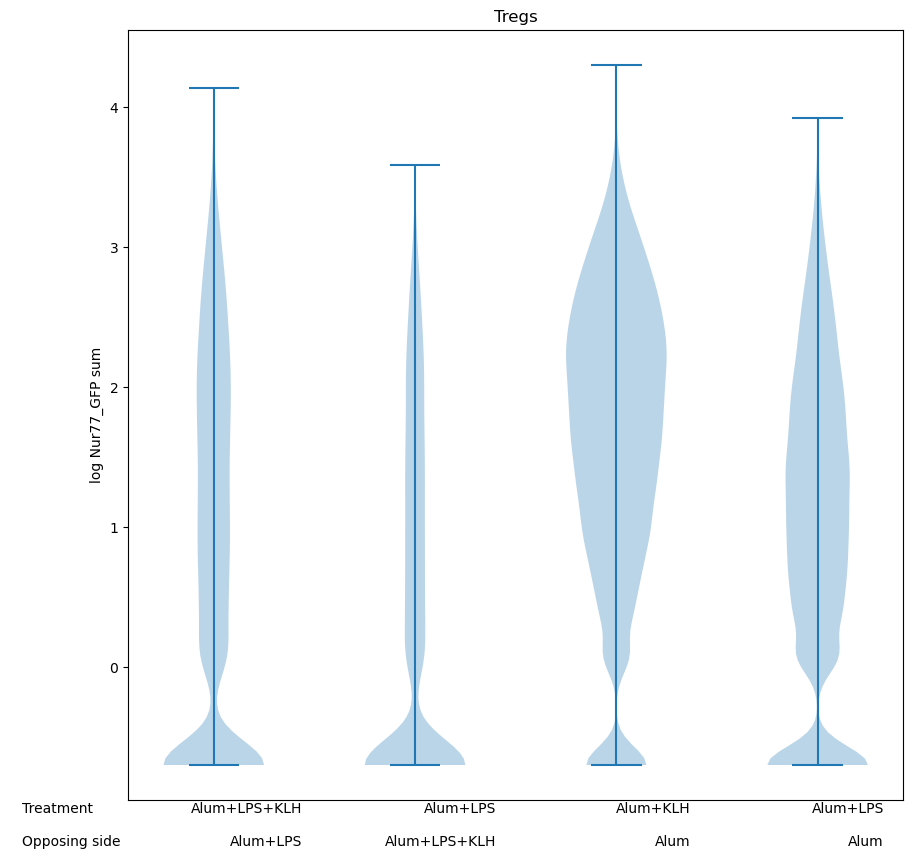

In [14]:
plot_data=[]
for sample in samples:
    temp_df=cells[sample+'_Treg']
    plot_data.append(temp_df['Intensity_Sum_Nur77_GFP'])
    # plot_data.append(temp_df[temp_df['Intensity_Sum_Nur77_GFP']>0]['Intensity_Sum_Nur77_GFP'])

plt.violinplot([np.log10(series+0.2) for series in plot_data])
plt.ylabel('log Nur77_GFP sum')
# plt.xticks([1,2,3,4],[conditions[sample] for sample in samples])'
plt.table(cellText=[[conditions[sample] for sample in samples],['' for sample in samples],[opposing_side_conditions[sample] for sample in samples]],
                      rowLabels=['Treatment','','Opposing side'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('Tregs')

Text(0.5, 1.0, 'alum+LPS+KLH')

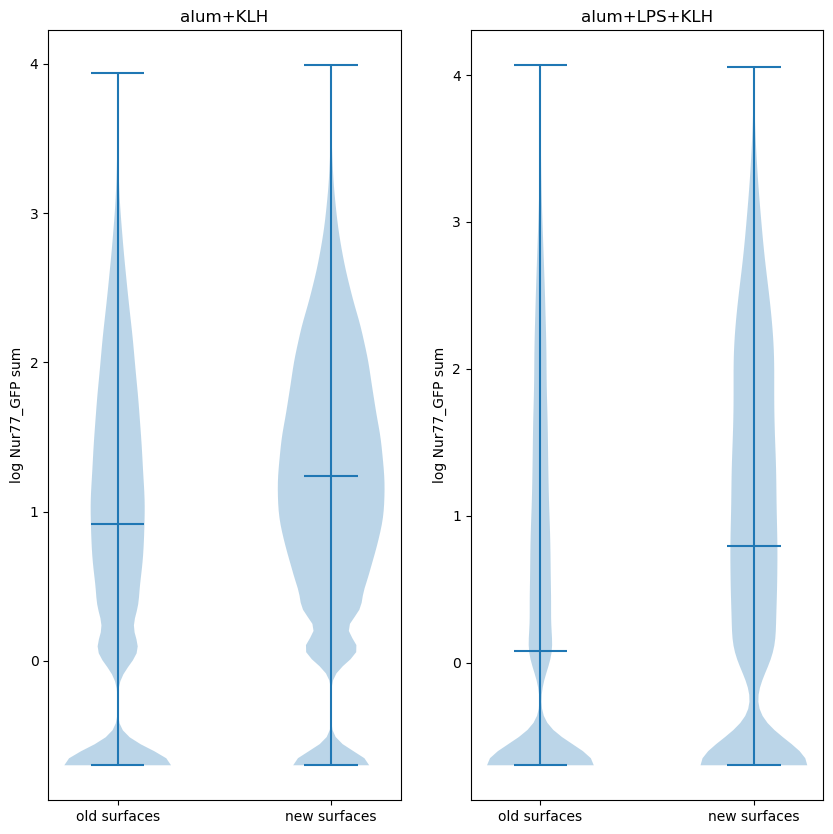

In [15]:
plot_data=[np.log10(cells['2L_Th']['Intensity_Sum_Nur77_GFP']+0.2),np.log10(Th_2l_resegment['Intensity_Sum_Nur77_GFP']+0.2)]
# plot_data=[arr[arr>-0.1] for arr in plot_data]
fig,axs=plt.subplots(1,2)
axs[0].violinplot(plot_data,showmedians=True)
axs[0].set_xticks([1,2],['old surfaces','new surfaces'])
axs[0].set_ylabel('log Nur77_GFP sum')
axs[0].set_title('alum+KLH')
plot_data=[np.log10(cells['1L_Th']['Intensity_Sum_Nur77_GFP']+0.2),np.log10(Th_1l_resegment['Intensity_Sum_Nur77_GFP']+0.2)]
# plot_data=[arr[arr>-0.1] for arr in plot_data]
axs[1].violinplot(plot_data,showmedians=True)
axs[1].set_xticks([1,2],['old surfaces','new surfaces'])
axs[1].set_ylabel('log Nur77_GFP sum')
axs[1].set_title('alum+LPS+KLH')

Text(0.5, 1.0, 'alum+LPS+KLH')

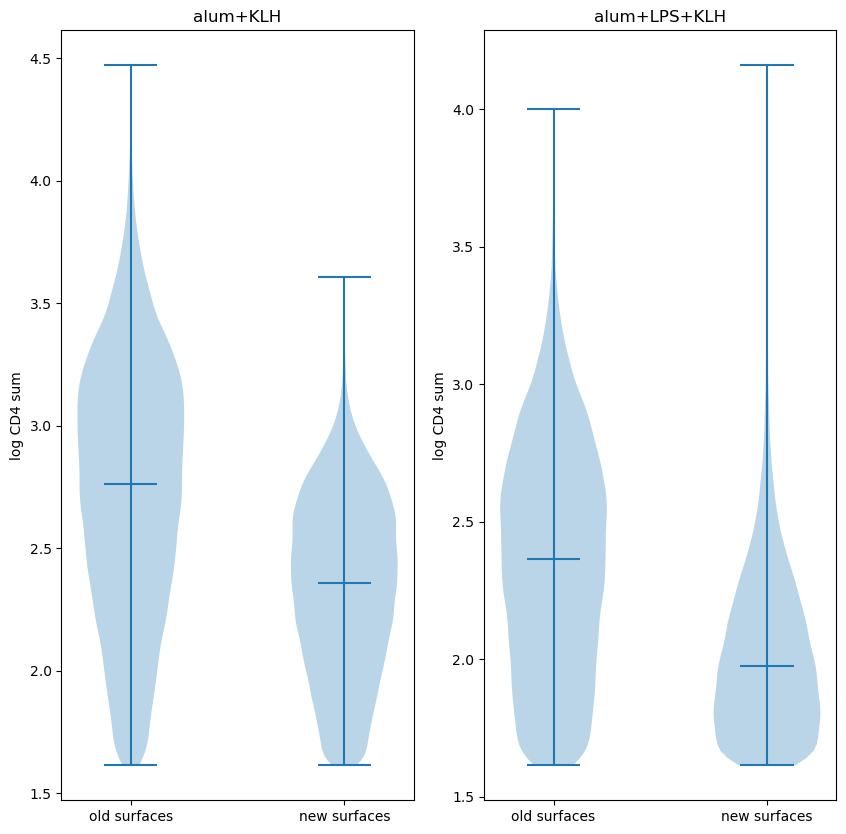

In [16]:
plot_data=[np.log10(cells['2L_Th']['Intensity_Sum_CD4']+0.2),np.log10(Th_2l_resegment['Intensity_Sum_CD4']+0.2)]
# plot_data=[arr[arr>-0.1] for arr in plot_data]
fig,axs=plt.subplots(1,2)
axs[0].violinplot(plot_data,showmedians=True)
axs[0].set_xticks([1,2],['old surfaces','new surfaces'])
axs[0].set_ylabel('log CD4 sum')
axs[0].set_title('alum+KLH')
plot_data=[np.log10(cells['1L_Th']['Intensity_Sum_CD4']+0.2),np.log10(Th_1l_resegment['Intensity_Sum_CD4']+0.2)]
# plot_data=[arr[arr>-0.1] for arr in plot_data]
axs[1].violinplot(plot_data,showmedians=True)
axs[1].set_xticks([1,2],['old surfaces','new surfaces'])
axs[1].set_ylabel('log CD4 sum')
axs[1].set_title('alum+LPS+KLH')

Text(0.5, 1.0, 'alum+LPS+KLH')

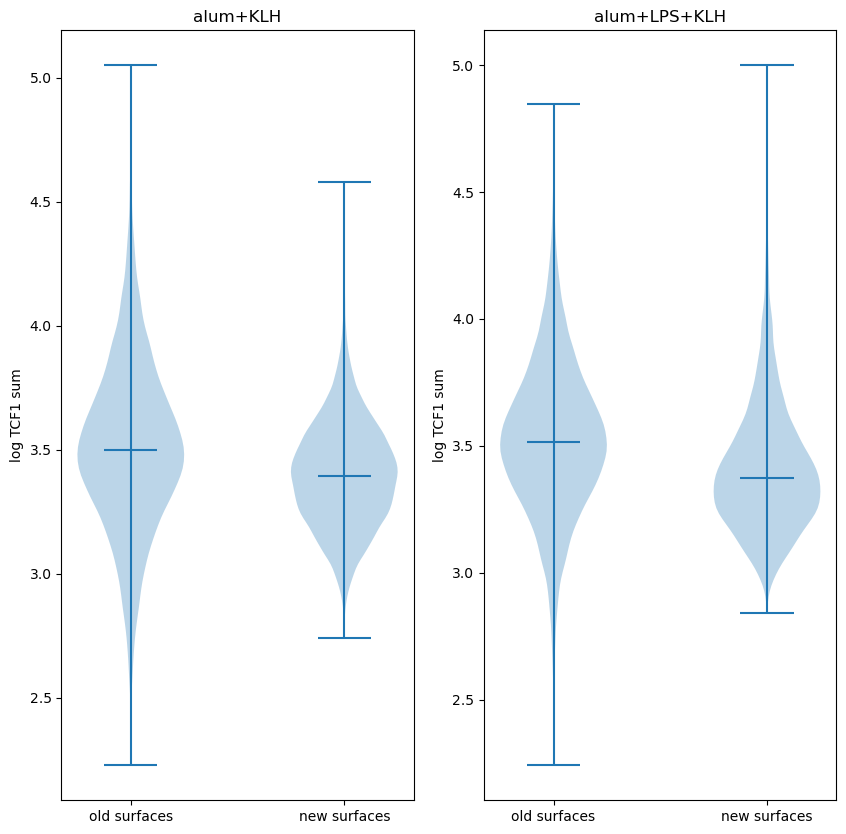

In [17]:
plot_data=[np.log10(cells['2L_Th']['Intensity_Sum_TCF1']+0.2),np.log10(Th_2l_resegment['Intensity_Sum_TCF1']+0.2)]
# plot_data=[arr[arr>-0.1] for arr in plot_data]
fig,axs=plt.subplots(1,2)
axs[0].violinplot(plot_data,showmedians=True)
axs[0].set_xticks([1,2],['old surfaces','new surfaces'])
axs[0].set_ylabel('log TCF1 sum')
axs[0].set_title('alum+KLH')
plot_data=[np.log10(cells['1L_Th']['Intensity_Sum_TCF1']+0.2),np.log10(Th_1l_resegment['Intensity_Sum_TCF1']+0.2)]
# plot_data=[arr[arr>-0.1] for arr in plot_data]
axs[1].violinplot(plot_data,showmedians=True)
axs[1].set_xticks([1,2],['old surfaces','new surfaces'])
axs[1].set_ylabel('log TCF1 sum')
axs[1].set_title('alum+LPS+KLH')

In [21]:
cells['2L_mig'].columns

Index(['Area', 'Cumulative_Volume_Img=1', 'Cumulative_Volume_Inside_Img=1',
       'Cumulative_Volume_Outside_Img=1', 'Distance_from_Origin',
       'Distance_to_Image_Border_XY_Img=1', 'Ellipticity_(oblate)',
       'Ellipticity_(prolate)', 'Generation', 'Intensity_TCF1',
       'Intensity_B220', 'Intensity_Nur77_GFP', 'Intensity_Foxp3',
       'Intensity_CD4', 'Intensity_CellTracker Deep Red',
       'Intensity_Inside_TCF1', 'Intensity_Inside_B220',
       'Intensity_Inside_Nur77_GFP', 'Intensity_Inside_Foxp3',
       'Intensity_Inside_CD4', 'Intensity_Inside_CellTracker Deep Red',
       'Intensity_Max_TCF1', 'Intensity_Max_B220', 'Intensity_Max_Nur77_GFP',
       'Intensity_Max_Foxp3', 'Intensity_Max_CD4',
       'Intensity_Max_CellTracker Deep Red', 'Intensity_Mean_TCF1',
       'Intensity_Mean_B220', 'Intensity_Mean_Nur77_GFP',
       'Intensity_Mean_Foxp3', 'Intensity_Mean_CD4',
       'Intensity_Mean_CellTracker Deep Red', 'Intensity_Median_TCF1',
       'Intensity_Median_B220'

Text(0, 0.5, 'log CTDR sum')

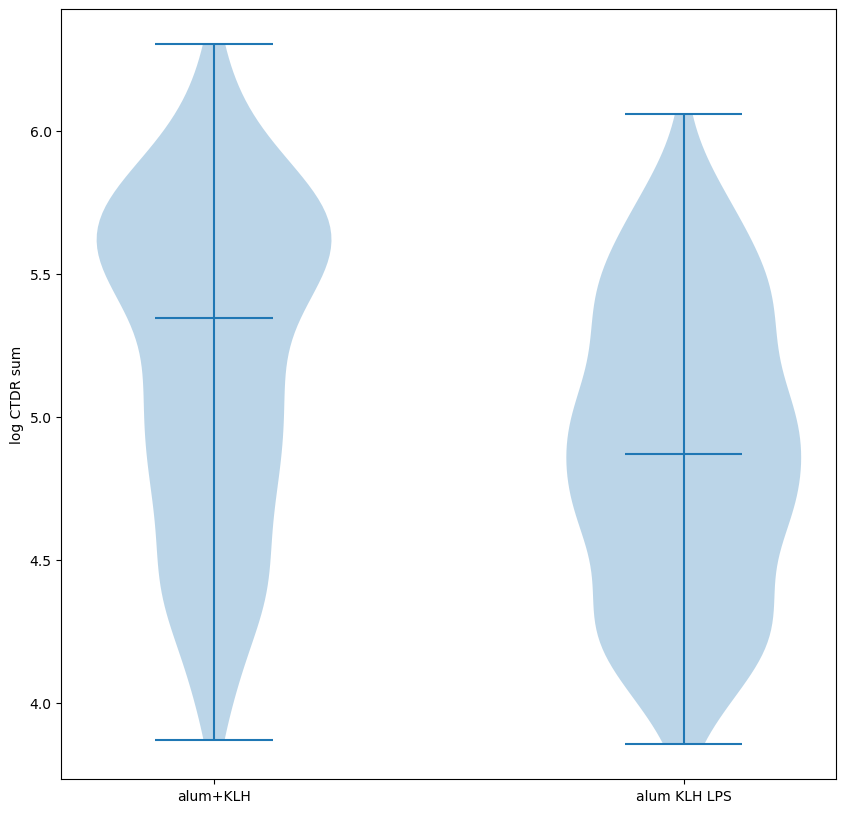

In [23]:
plot_data=[np.log10(cells['2L_mig']['Intensity_Sum_CellTracker Deep Red']+0.2),np.log10(cells['1L_mig']['Intensity_Sum_CellTracker Deep Red']+0.2)]
# plot_data=[arr[arr>-0.1] for arr in plot_data]
fig,axs=plt.subplots(1,1)
axs.violinplot(plot_data,showmedians=True)
axs.set_xticks([1,2],['alum+KLH','alum KLH LPS'])
axs.set_ylabel('log CTDR sum')


Text(0.5, 1.0, 'alum+LPS+KLH')

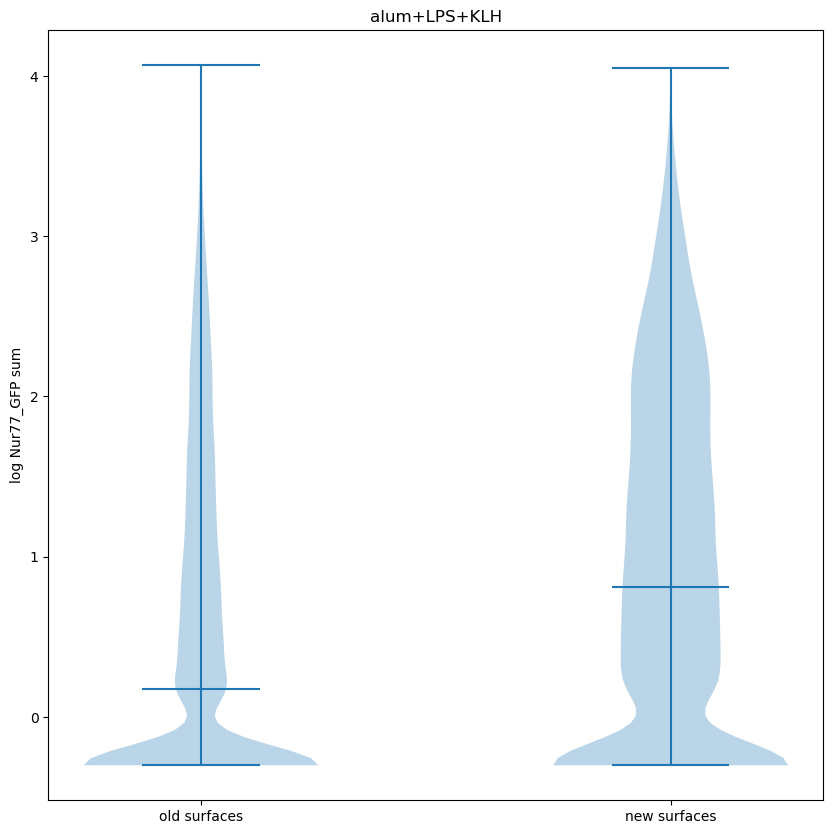

Text(0.5, 1.0, 'CD4 Tconv')

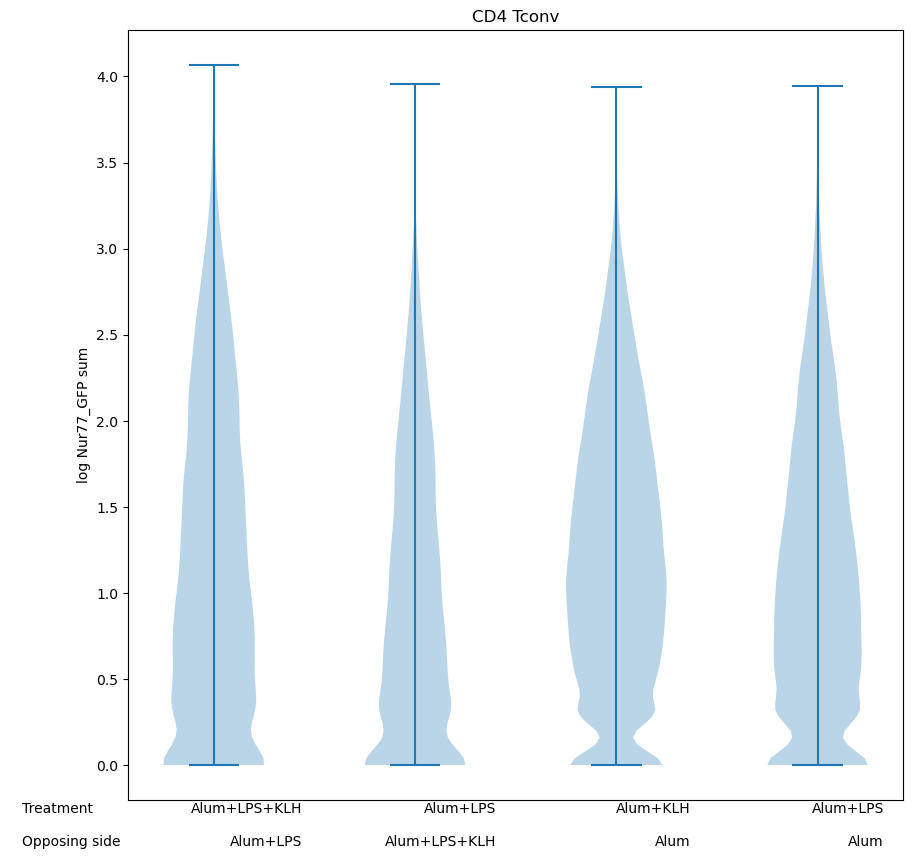

In [45]:
plot_data=[]
for sample in samples:
    temp_df=cells[sample+'_Th']
    plot_data.append(temp_df[temp_df['Intensity_Sum_Nur77_GFP']>0]['Intensity_Sum_Nur77_GFP'])

plt.violinplot([np.log10(series) for series in plot_data])
plt.ylabel('log Nur77_GFP sum')
plt.table(cellText=[[conditions[sample] for sample in samples],['' for sample in samples],[opposing_side_conditions[sample] for sample in samples]],
                      rowLabels=['Treatment','','Opposing side'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('CD4 Tconv')

In [47]:
scipy.stats.kstest(plot_data[1],plot_data[3])

KstestResult(statistic=0.05239549251152967, pvalue=2.153509250964187e-14)

In [ ]:
scipy.stats.kstest(plot_data[1],plot_data[3]) 

In [48]:
scipy.stats.kstest(plot_data[0],plot_data[2])

KstestResult(statistic=0.14965398418790798, pvalue=1.1396712736579482e-220)

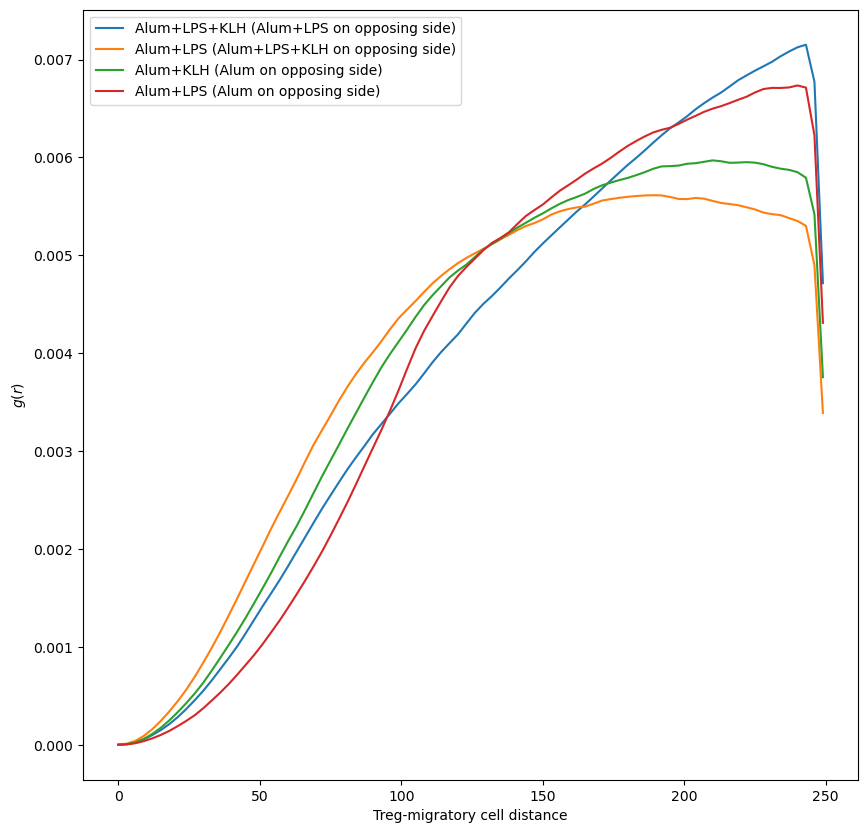

In [23]:
plot_data=[cell_pairs[sample+'_Treg_mig'].flatten() for sample in samples]
plot_data=[series[series<250] for series in plot_data]
kde_objs=[scipy.stats.gaussian_kde(series) for series in plot_data]
x_range=np.arange(0,50,3)
for i,sample in enumerate(samples):
    plt.plot(x_range,kde_objs[i](x_range),label=f'{conditions[sample]} ({opposing_side_conditions[sample]} on opposing side)')
plt.xlabel('Treg-migratory cell distance')
plt.ylabel('$g(r)$')
plt.legend()


In [ ]:
plot_data=[cell_pairs[sample+'_Treg_mig'].flatten() for sample in samples]
plot_data=[series[series<250] for series in plot_data]


In [11]:
plot_data

[array([870.59470752, 851.25992374, 857.83603719, ..., 754.73185563,
        665.44567051, 681.82569081]),
 array([415.26170084, 388.28097046, 374.10274825, ..., 229.30935712,
        236.366112  , 339.78297741]),
 array([385.52244029, 415.63856062, 404.23473603, ..., 160.81292045,
        172.2067303 , 198.72652979]),
 array([300.75094388, 302.10584919, 411.50034603, ..., 603.35071366,
        666.37638825, 663.58934114])]

In [38]:
normalize=lambda arr,i:arr/arr[i]

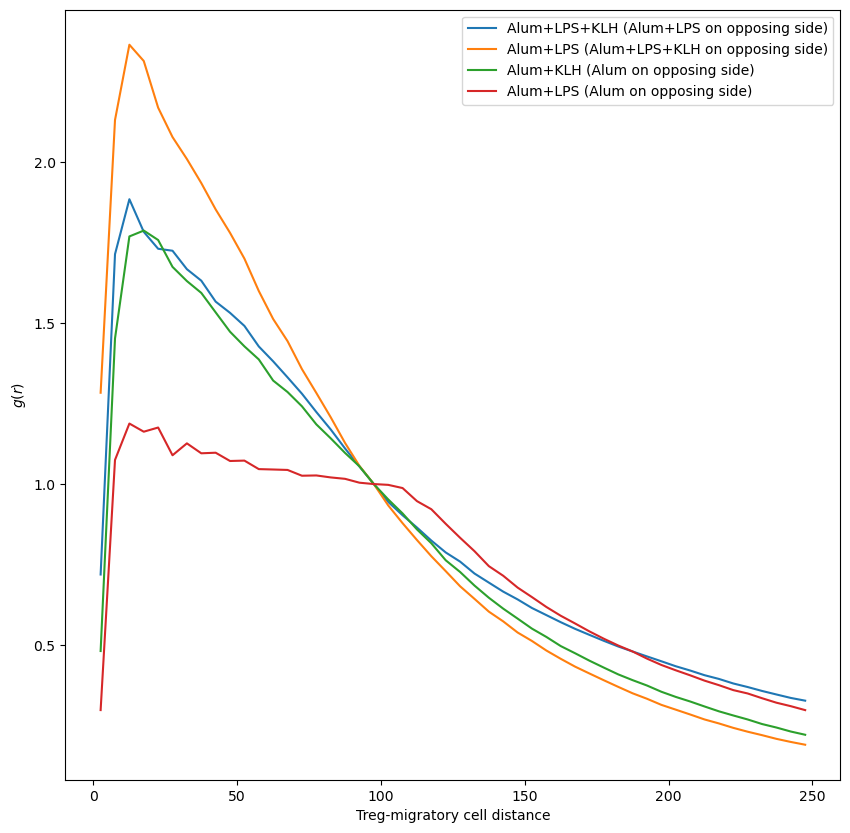

In [39]:
plot_data=[cell_pairs[sample+'_Treg_mig'].flatten() for sample in samples]
plot_data=[series[series<250] for series in plot_data]
hist=[np.histogram(series,bins=np.arange(0,251,5))[0] for series in plot_data]
bin_midpts=np.arange(2.5,250,5)
for i,sample in enumerate(samples):
    plt.plot(bin_midpts,normalize(hist[i]/bin_midpts**2,19),label=f'{conditions[sample]} ({opposing_side_conditions[sample]} on opposing side)')
plt.xlabel('Treg-migratory cell distance')
plt.ylabel('$g(r)$')
plt.legend()

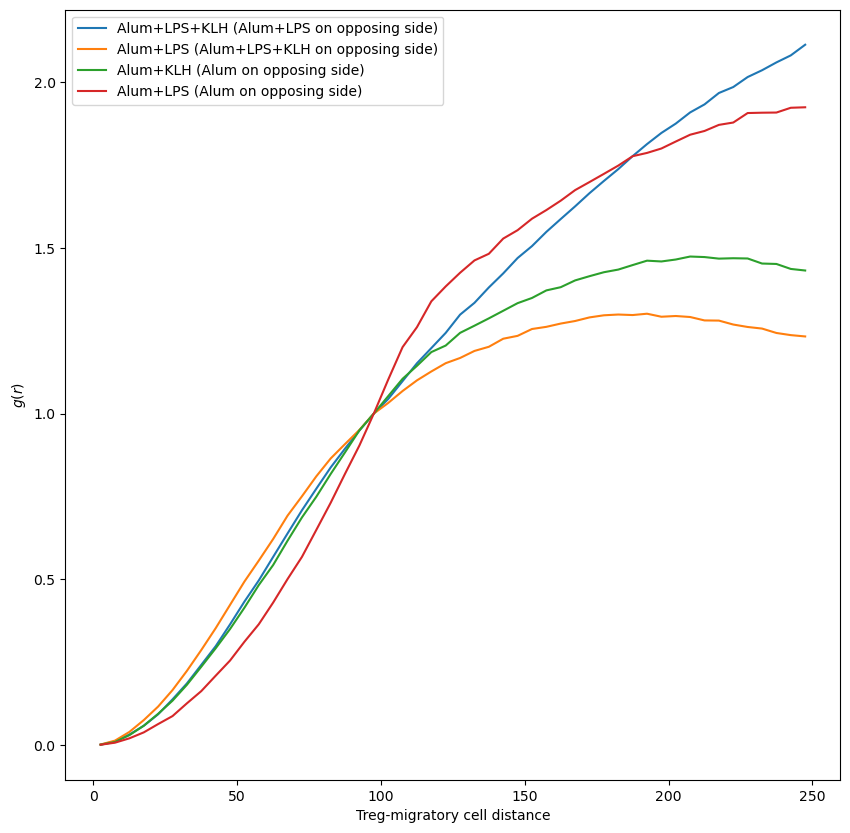

In [40]:
plot_data=[cell_pairs[sample+'_Treg_mig'].flatten() for sample in samples]
plot_data=[series[series<250] for series in plot_data]
hist=[np.histogram(series,bins=np.arange(0,251,5))[0] for series in plot_data]
bin_midpts=np.arange(2.5,250,5)
for i,sample in enumerate(samples):
    plt.plot(bin_midpts,normalize(hist[i],19),label=f'{conditions[sample]} ({opposing_side_conditions[sample]} on opposing side)')
plt.xlabel('Treg-migratory cell distance')
plt.ylabel('$g(r)$')
plt.legend()

Text(0.5, 1.0, 'CD4 Tconv')

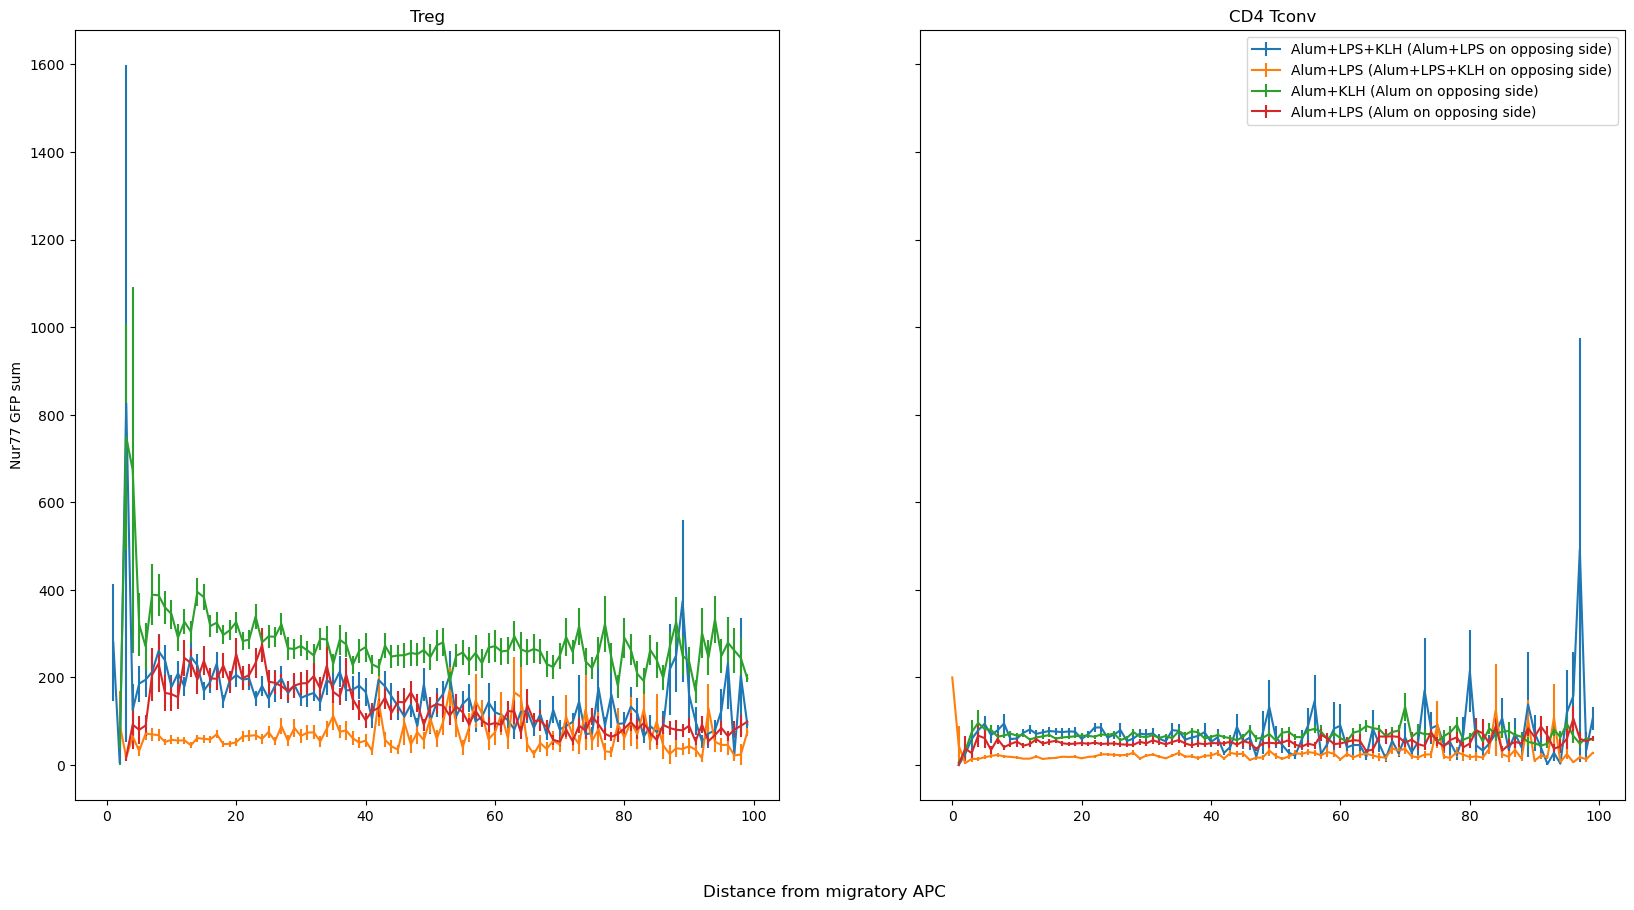

In [119]:
bin_width=1
n_bins=100
fig,axs=plt.subplots(1,2,sharex=True,sharey=True,figsize=(20,10))
for sample in samples:
    for i,cell_type in enumerate(['Treg','Th']):
        val_container=[[] for _ in range(n_bins)]
        for _,cell in cells[f'{sample}_{cell_type}'].iterrows():
            val_container[min(int(cell['Distance_mig']//bin_width),99)].append(cell['Intensity_Sum_Nur77_GFP'])
        mean_arr=[np.mean(bin_vals) for bin_vals in val_container]
        std_arr=[scipy.stats.sem(bin_vals) for bin_vals in val_container]
        axs[i].errorbar(np.arange(0,bin_width*n_bins,bin_width),mean_arr,yerr=std_arr,label=f'{conditions[sample]} ({opposing_side_conditions[sample]} on opposing side)')
fig.supxlabel('Distance from migratory APC')
axs[0].set_ylabel('Nur77 GFP sum')
axs[1].legend()
axs[0].set_title('Treg')
axs[1].set_title('CD4 Tconv')